In [1]:
import torch
from config import *
from utils import *

import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)  # Example: Ignore deprecation warnings
warnings.simplefilter("ignore")  # Ignore all warnings


In [2]:
data_sources = [
    "real", # 0
    "stylegan-", # 1
    "stylegan2", # 2
    "stylegan3", # 3
    # "progan", # 4

    # "dalle3", # 5 
    "mjv6", # 6
    # "ld", # 7
    # "firefly", # 8
    # "sd3", # 9
    "tam_trans", # 10
]
X_train, X_test, y_train, y_test = get_datasets(data_sources, prefix=prefix)
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3, 4, 5]), array([774, 825, 800, 786, 809, 806])),
 (array([0, 1, 2, 3, 4, 5]), array([226, 175, 200, 214, 191, 194])))

In [3]:
scores = np.zeros((len(y_test), len(data_sources)))
mkl = len(data_sources) - 1
ink = 4
results, lists = get_metrics(scores, y_test, max_known_label=mkl, initial_n_known=ink)
results

[226 175 200 214 191 194]
[1200]
[[226   0   0   0   0   0]
 [175   0   0   0   0   0]
 [200   0   0   0   0   0]
 [214   0   0   0   0   0]
 [191   0   0   0   0   0]
 [194   0   0   0   0   0]]


{'acc_init': 0.25,
 'acc': 0.1667,
 'acc_curr': 0.0,
 'acc_syn_init': 0.5,
 'acc_syn': 0.5,
 'acc_syn_curr': 0.0,
 'auc_crr': nan,
 'oscr': 0}

In [4]:
import torch
import torch.nn.functional as F

def online_triplet_mining(embeddings, labels, class_weights=None, margin=1.0, top_k=1):
    batch_size = embeddings.size(0)
    triplet_loss = 0.0
    
    for i in range(batch_size):
        anchor = embeddings[i]
        anchor_label = labels[i]

        # Find positives (same class) excluding the anchor itself
        positive_mask = (labels == anchor_label) & (torch.arange(batch_size).cuda() != i)
        positives = embeddings[positive_mask]

        # Find negatives (different class)
        negative_mask = labels != anchor_label
        negatives = embeddings[negative_mask]

        if positives.size(0) > 0 and negatives.size(0) > 0:
            # Compute distances for positives and negatives
            positive_distances = torch.norm(positives - anchor, dim=1)
            negative_distances = torch.norm(negatives - anchor, dim=1)

            # Select the top_k hardest positives (smallest distances)
            hardest_positives = positives[torch.argsort(positive_distances)[:top_k]]

            # Select the top_k hardest negatives (smallest distances)
            hardest_negatives = negatives[torch.argsort(negative_distances)[:top_k]]
            
            # Compute the loss for each selected triplet and average
            loss = 0.0
            for hp in hardest_positives:
                for hn in hardest_negatives:
                    loss += F.relu(
                        torch.norm(anchor - hp, p=2) ** 2 - torch.norm(anchor - hn, p=2) ** 2 + margin
                    )
            loss /= (top_k * top_k)  # Normalize over the number of triplets
            
            # Scale loss by the class weight of the anchor
            # loss = loss * class_weights[anchor_label]  # Uncomment if class weights are provided
            triplet_loss += loss

    return triplet_loss / batch_size



In [5]:
def train_autoencoder(
    X_train,
    y_train,
    X_val,
    y_val,
    source_name,
    max_known_label,
    initial_n_known,
    kwargs,
):
    """
    Trains an autoencoder using in-memory datasets with weighted loss terms.

    Args:
        model: The autoencoder model.
        X_train: Training images (tensor).
        y_train: Training labels (tensor).
        X_val: Validation images (tensor).
        y_val: Validation labels (tensor).
        discriminative_loss_fn: Predefined discriminative loss function.
        num_epochs: Number of training epochs.
        lr: Initial learning rate.
        weight_decay: Weight decay for optimizer.
        device: Device to run training on.
        alpha: Weight for L1 reconstruction loss.
        beta: Weight for discriminative loss.
    """
    num_epochs = 20
    alpha = 1.0
    beta = 100.0
    batch_size = 64
    lr = 1e-4
    top_k = 1

    num_epochs = kwargs.get("num_epochs", num_epochs)
    alpha = kwargs.get("alpha", alpha)
    beta = kwargs.get("beta", beta)
    batch_size = kwargs.get("batch_size", batch_size)
    lr = kwargs.get("lr", lr)
    pl_patience = kwargs.get("pl_patience", 1)
    es_patience = kwargs.get("es_patience", 10)
    top_k = kwargs.get("top_k", top_k)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model and data to device
    input_dim, hidden_dim, latent_dim = 640, 640, 640
    model = Autoencoder(input_dim, hidden_dim, latent_dim)
    model = model.to(device)

    # shuffle the data
    # X_train, y_train = shuffle(X_train, y_train)
    # X_val, y_val = shuffle(X_val, y_val)

    X_train, X_val = torch.tensor(X_train).float(), torch.tensor(X_val).float()
    y_train, y_val = torch.tensor(y_train).long(), torch.tensor(y_val).long()

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)

    # Loss function and optimizer
    reconstruction_loss = nn.L1Loss()
    discriminative_loss_fn = online_triplet_mining
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=pl_patience, verbose=True
    )

    # TensorBoard writer
    writer = SummaryWriter(log_dir=f"runs/{source_name}")

    # Early stopping parameters
    best_val_loss = float("inf")
    early_stop_counter = 0

    num_train_batches = (len(X_train) + batch_size - 1) // batch_size
    num_val_batches = (len(X_val) + batch_size - 1) // batch_size
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        # Validation phase
        model.eval()
        val_recon_loss = 0.0
        val_disc_loss = 0.0
        total_val_loss = 0.0

        with torch.no_grad():
            for i in range(num_val_batches):
                start, end = i * batch_size, (i + 1) * batch_size
                batch_X, labels = X_val[start:end], y_val[start:end]

                outputs = model(batch_X)

                loss_reconstruction = reconstruction_loss(outputs, batch_X) * alpha
                loss_discriminative = discriminative_loss_fn(outputs, labels, top_k=top_k) * beta

                loss = loss_reconstruction + loss_discriminative

                val_recon_loss += loss_reconstruction.item()
                if loss_discriminative > 0 and isinstance(
                    loss_discriminative, torch.Tensor
                ):
                    val_disc_loss += loss_discriminative.item()
                total_val_loss += loss.item()

            X_train_transformed = model(X_train).detach().cpu().numpy()
            X_val_transformed = model(X_val).detach().cpu().numpy()

        gmms = {}
        y_train_np = y_train.cpu().numpy()
        y_val_np = y_val.cpu().numpy()
        for label in np.unique(y_train_np):
            X_train_transformed_label = X_train_transformed[y_train_np == label]
            gmm_model = GaussianMixture(n_components=5, covariance_type="full")
            gmm_model.fit(X_train_transformed_label)
            gmms[label] = gmm_model

        scores = np.zeros((X_val_transformed.shape[0], len(gmms)))
        for i, key in enumerate(gmms):
            gmm_model = gmms[key]
            scores[:, i] = gmm_model.score_samples(X_val_transformed)

        preds = np.argmax(scores, axis=1)
        cm = confusion_matrix(y_val_np, preds)
        print(cm)

        results = {}
        accuracy = np.mean(preds == y_val_np)
        y_is_synthetic = (y_val_np > 0).astype(int)
        preds_synthetic = (preds > 0).astype(int)
        acc_synthetic = np.mean(y_is_synthetic == preds_synthetic)
        results["acc"] = accuracy
        results["acc_syn"] = acc_synthetic
        for key, value in results.items():
            writer.add_scalar(f"Metrics/{key}", value, epoch)

        # Compute average validation losses
        val_recon_loss /= num_val_batches
        val_disc_loss /= num_val_batches
        total_val_loss /= num_val_batches

        # Training phase
        model.train()
        train_recon_loss = 0.0
        train_disc_loss = 0.0
        total_train_loss = 0.0

        for i in range(num_train_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            batch_X, labels = X_train[start:end], y_train[start:end]

            optimizer.zero_grad()
            outputs = model(batch_X)

            # Forward pass
            loss_reconstruction = reconstruction_loss(outputs, batch_X) * alpha
            loss_discriminative = discriminative_loss_fn(outputs, labels, top_k=top_k) * beta

            loss = loss_reconstruction + loss_discriminative

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Track losses
            train_recon_loss += loss_reconstruction.item()
            if loss_discriminative > 0 and isinstance(
                loss_discriminative, torch.Tensor
            ):
                train_disc_loss += loss_discriminative.item()
            total_train_loss += loss.item()

        # Compute average training losses
        train_recon_loss /= num_train_batches
        train_disc_loss /= num_train_batches
        total_train_loss /= num_train_batches

        # Adjust learning rate if validation loss plateaus
        scheduler.step(total_val_loss)
        # Log losses to TensorBoard
        writer.add_scalar("Loss/Train_Recon", train_recon_loss, epoch)
        writer.add_scalar("Loss/Train_Discriminative", train_disc_loss, epoch)
        writer.add_scalar("Loss/Train_Total", total_train_loss, epoch)
        writer.add_scalar("Loss/Val_Recon", val_recon_loss, epoch)
        writer.add_scalar("Loss/Val_Discriminative", val_disc_loss, epoch)
        writer.add_scalar("Loss/Val_Total", total_val_loss, epoch)
        writer.add_scalar("Learning_Rate", optimizer.param_groups[0]["lr"], epoch)

        # Print progress
        print(
            f"Epoch [{epoch+1}/{num_epochs}] - Train Loss1: {train_recon_loss:.4f}, Train Loss2: {train_disc_loss:.4f}, Train TLoss: {total_train_loss:.4f}",
            end="",
        )
        print(
            f", Val Loss1: {val_recon_loss:.4f}, Val Loss2: {val_disc_loss:.4f}, Val TLoss: {total_val_loss:.4f}, Accuracy: {accuracy:.4f}, Detection Acc: {acc_synthetic:.4f}"
        )

        # Early stopping logic
        val_loss_eps = 0.01
        if total_val_loss < best_val_loss and abs(total_val_loss - best_val_loss) > val_loss_eps:
            best_val_loss = total_val_loss
            best_accuracy = accuracy
            best_detected_accuracy = acc_synthetic
            best_epoch = epoch
            early_stop_counter = 0  # Reset counter
            best_model = deepcopy(model)
        else:
            early_stop_counter += 1

        if early_stop_counter >= es_patience:
            print(
                f"Early stopping triggered after {epoch+1} epochs at epoch {best_epoch+1} ", end=""
            )
            print(f"with validation loss: {best_val_loss:.4f} and accuracy: {best_accuracy:.4f}, detection accuracy: {best_detected_accuracy:.4f}")
            return best_model.eval().cpu()

    # Close TensorBoard writer
    writer.close()

    return model.eval().cpu()

In [6]:
train_size = 1375

X_train, y_train = shuffle(X_train, y_train)
X_train, y_train = X_train[:train_size], y_train[:train_size]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
np.unique(y_train, return_counts=True), np.unique(y_val, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3, 4, 5]), array([190, 202, 173, 194, 153, 188])),
 (array([0, 1, 2, 3, 4, 5]), array([35, 46, 50, 45, 36, 63])),
 (array([0, 1, 2, 3, 4, 5]), array([226, 175, 200, 214, 191, 194])))

In [7]:
training_kwargs = {
    "num_epochs": 50,
    "alpha": 1.0,
    "beta": 5.0,
    "batch_size": 64,
    "lr": 2.5e-5,
    "pl_patience": 0,
    "es_patience": 3,
    "top_k": 1,
}

auto_encoder = train_autoencoder(
    X_train,
    y_train,
    X_test,
    y_test,
    max_known_label=mkl,
    initial_n_known=ink,
    source_name="test",
    kwargs=training_kwargs,
)

[[223   0   0   1   2   0]
 [  0 170   3   1   1   0]
 [  0   3 194   2   1   0]
 [  0   0   4 202   8   0]
 [  0   0   4  23 164   0]
 [  0   0   0   0   0 194]]
Epoch [1/50] - Train Loss1: 4.7480, Train Loss2: 2.8256, Train TLoss: 7.5736, Val Loss1: 4.6916, Val Loss2: 3.4269, Val TLoss: 8.1185, Accuracy: 0.9558, Detection Acc: 0.9975
[[221   2   0   1   2   0]
 [  0 173   0   1   1   0]
 [  0   8 191   1   0   0]
 [  0   1   1 209   3   0]
 [  0   2   1  16 172   0]
 [  0   0   0   0   0 194]]
Epoch [2/50] - Train Loss1: 4.7457, Train Loss2: 1.6449, Train TLoss: 6.3906, Val Loss1: 4.6886, Val Loss2: 2.4939, Val TLoss: 7.1825, Accuracy: 0.9667, Detection Acc: 0.9958
[[222   1   0   1   2   0]
 [  2 166   1   3   3   0]
 [  0   3 188   5   4   0]
 [  0   0   0 202  12   0]
 [  1   0   0  16 174   0]
 [  0   0   0   0   0 194]]
Epoch [3/50] - Train Loss1: 4.7435, Train Loss2: 0.8960, Train TLoss: 5.6394, Val Loss1: 4.6867, Val Loss2: 1.7123, Val TLoss: 6.3990, Accuracy: 0.9550, Detectio

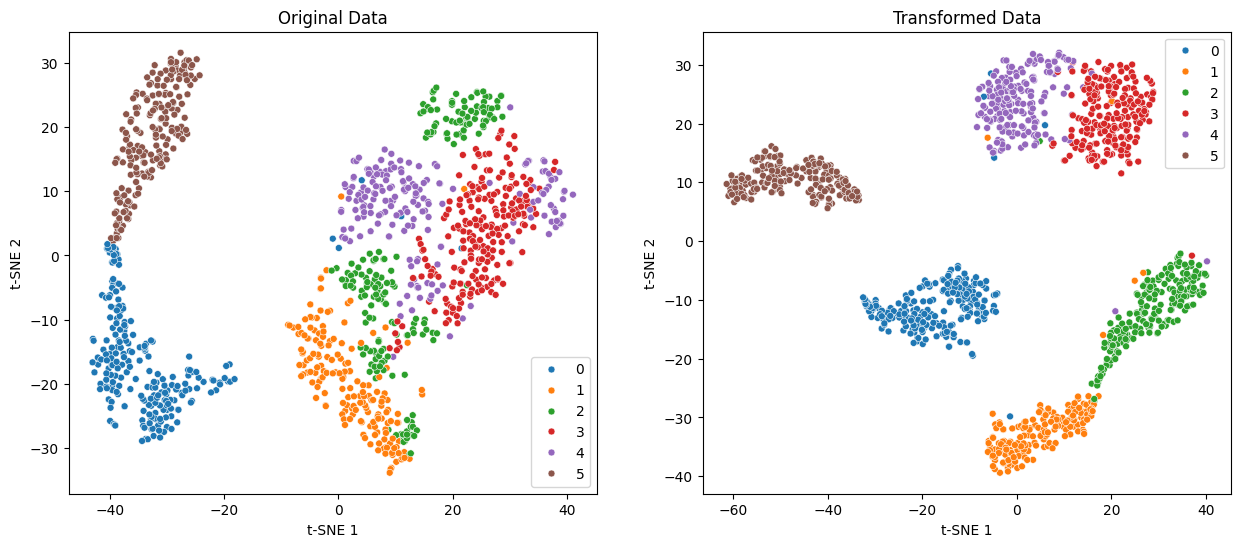

In [8]:
# plot X_test and X_test transformed
X_test_transformed = auto_encoder(torch.tensor(X_test).float()).detach().cpu().numpy()
X_tsne_test = TSNE(n_components=2).fit_transform(X_test)
X_tsne_test_transformed = TSNE(n_components=2).fit_transform(X_test_transformed)

X_test_pca = PCA(n_components=2).fit_transform(X_test)
X_test_transformed_pca = PCA(n_components=2).fit_transform(X_test_transformed)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x=X_tsne_test[:, 0], y=X_tsne_test[:, 1], hue=y_test, ax=ax[0], palette="tab10", s=25)
ax[0].set_title("Original Data")
ax[0].set_xlabel("t-SNE 1")
ax[0].set_ylabel("t-SNE 2")
sns.scatterplot(x=X_tsne_test_transformed[:, 0], y=X_tsne_test_transformed[:, 1], hue=y_test, ax=ax[1], palette="tab10", s=25)
ax[1].set_title("Transformed Data")
ax[1].set_xlabel("t-SNE 1")
ax[1].set_ylabel("t-SNE 2")
plt.show()
